In [30]:
from __future__ import print_function

import os
import glob
import rosbag
import pandas as pd
import numpy as np
import cv2
import time 

import ipywidgets as widgets
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

from os import path
from utils.visualisation import *
from utils.postprocessing.utils import csvs2dfs
from functools import reduce
from ipywidgets import interact, interactive, fixed, interact_manual
from utils.visualisation import *
from utils.postprocessing.utils import *
from matplotlib import gridspec
from env.spawn.SpawnStragety import FlatGroundSpawnStrategy

In [31]:
from utils.visualisation import VisualiseSimulation

In [32]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
%%html
<style>

div.output_scroll {
    height : auto;
}
</style>

# Visualize the simulation
Visualize the robot's simulation on a specific map is tremendously useful to understand if everything went perfect. Also, we can have an idea about the generated dataset.

In [34]:
def folder2maps(folder):
    maps = glob.glob('/home/francesco/Documents/Master-Thesis/core/maps/{}/*.png'.format(folder))
    return maps, list(map(lambda x : path.splitext(path.basename(x))[0], maps))


def map2dfs(hm_path, csv_path):
    hm = cv2.imread(hm_path)
    hm = cv2.cvtColor(hm, cv2.COLOR_BGR2GRAY)
    
    csvs_dir = csv_path
    print(csvs_dir)
    csvs_paths = glob.glob(csvs_dir)
    
    csvs_paths.sort()
    
    dfs = csvs2dfs(csvs_paths)
    print(len(dfs))
    return csvs_paths, dfs, hm

In [35]:
FOLDER = '92'
MODE = 'train'
MAP_NAME = 'bars1'

In [36]:
csvs_paths, dfs, hm  = map2dfs('/home/francesco/Documents/Master-Thesis/core/maps/{}/{}.png'.format(MODE, MAP_NAME)
                               , '/home/francesco/Desktop/carino/vaevictis/krock-dataset/{}/{}/csvs-light/{}/*.csv'.format(FOLDER, MODE, MAP_NAME)
                              )

/home/francesco/Desktop/carino/vaevictis/krock-dataset/92/train/csvs-light/bars1/*.csv
100


## Plotting statistics

In [37]:
def plot_stats(df):
    fig = plt.figure()
    df['advancement'].plot.line()

    fig = plt.figure()
    df['advancement'].plot.box()
    print('mean={}'.format(df['advancement'].mean()))
    

In [38]:
def concat_dfs(dfs):
    df_total = pd.concat(filter(lambda x: len(x) > 0, dfs))
    df_total = df_total.dropna()
    df_total = df_total.reset_index(drop=True) # we need to reset the index otherwise the plots are based on the old overlapping indexes
    
    return df_total

In [39]:
df = concat_dfs(dfs)

### Classes Balance

In [40]:
trs = np.arange(0.04,0.15,0.01)

def plot_classes_distribution(tr, remove_negative):
    temp = df.copy()
    if remove_negative: temp = temp[temp.loc[:,'advancement'] >= 0]
    temp['label'] = temp['advancement'] > tr
    temp['label'].value_counts().plot.bar()
    
    
interact(plot_classes_distribution, tr=trs, remove_negative=False)


interactive(children=(Dropdown(description='tr', options=(0.04, 0.05, 0.060000000000000005, 0.07, 0.0800000000…

<function __main__.plot_classes_distribution(tr, remove_negative)>

The following pictures shows the advancement in time after stacking all the dataframe one after the others, and the box plot.

### Average statistics for all the dataframes

<IPython.core.display.Javascript object>


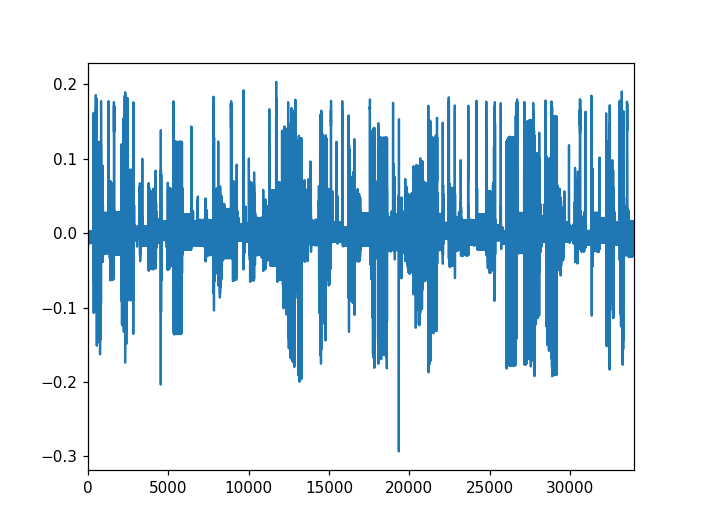

<IPython.core.display.Javascript object>


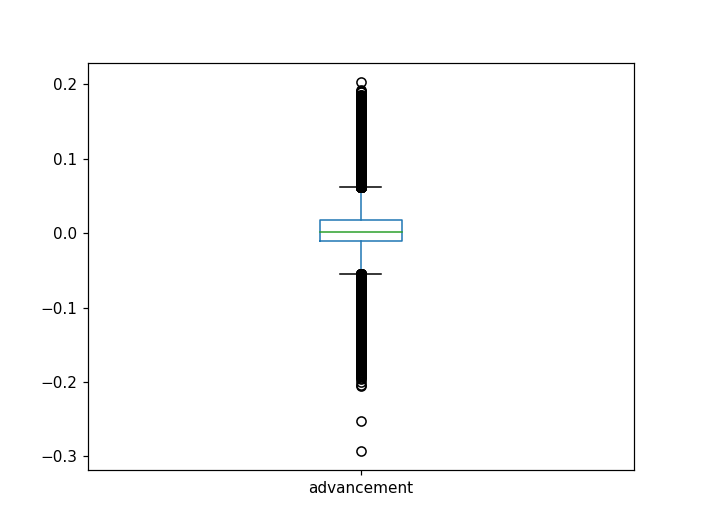

mean=0.005752703180905762


In [41]:
plot_stats(df)

### Remove negative advancement
By removing negative advancement we have a cleaner distribution of the data points

<IPython.core.display.Javascript object>


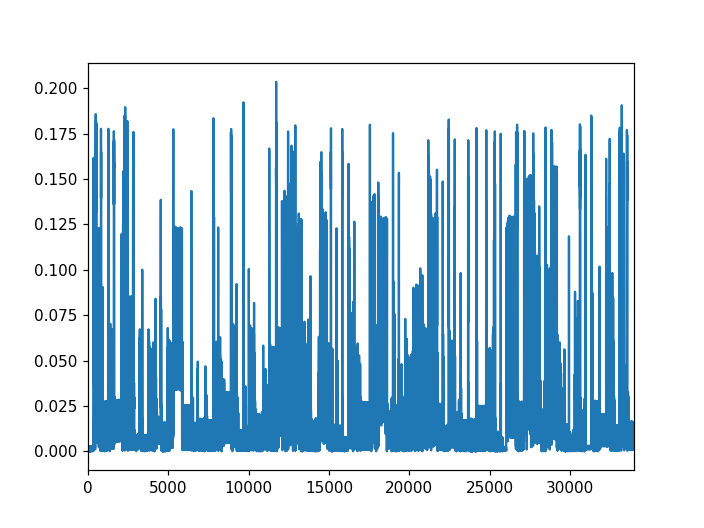

<IPython.core.display.Javascript object>


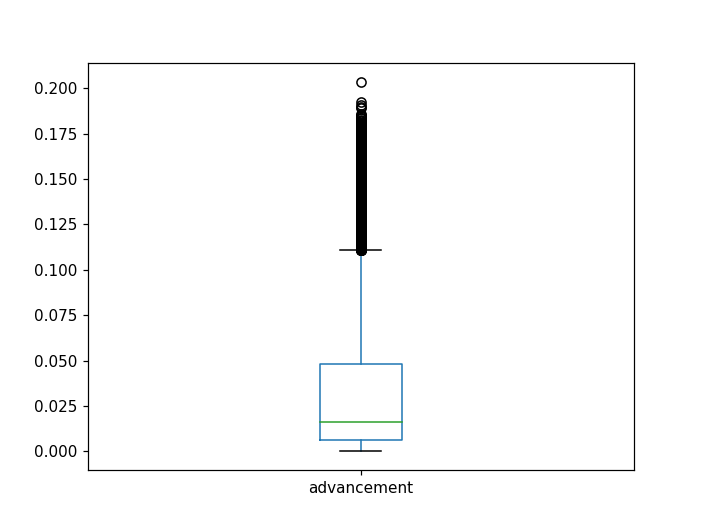

mean=0.03473295417543558


In [42]:
plot_stats(df[df["advancement"] >= 0])

### Robot traces 

<IPython.core.display.Javascript object>


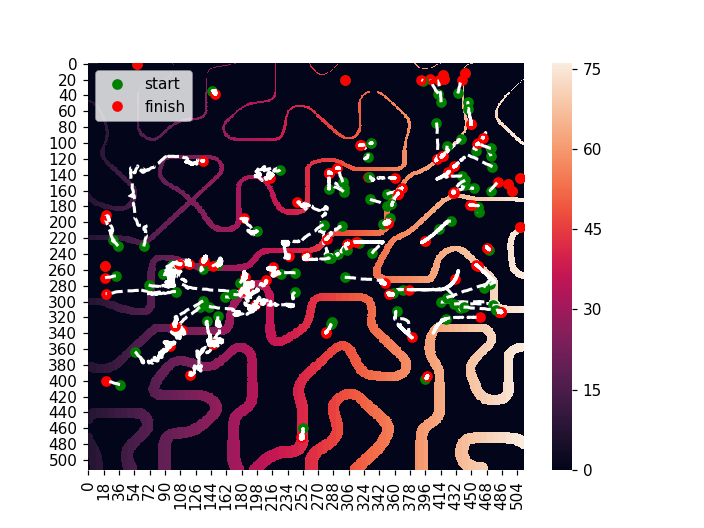

In [44]:
deb_pip = VisualiseSimulation(hm, patch_size=92)
deb_pip.show_traces(dfs)

### Robot patches and robot's position and angle for a given map

In [45]:
%%html
<style>

div.output_scroll {
    height : auto !important;
}
</style>

In [46]:
def csv_path2debug(csv_path, remove_negative):
    idx = csvs_paths.index(csv_path)
    print(remove_negative, idx)
    temp = dfs[idx].copy()
    if remove_negative: temp = temp[temp.loc[:,'advancement'] >= 0]
    deb_pip(temp)
    

interact(csv_path2debug, csv_path=csvs_paths, remove_negative=False)

interactive(children=(Dropdown(description='csv_path', options=('/home/francesco/Desktop/carino/vaevictis/kroc…

<function __main__.csv_path2debug(csv_path, remove_negative)>

number 10 robot is stuck

<IPython.core.display.Javascript object>


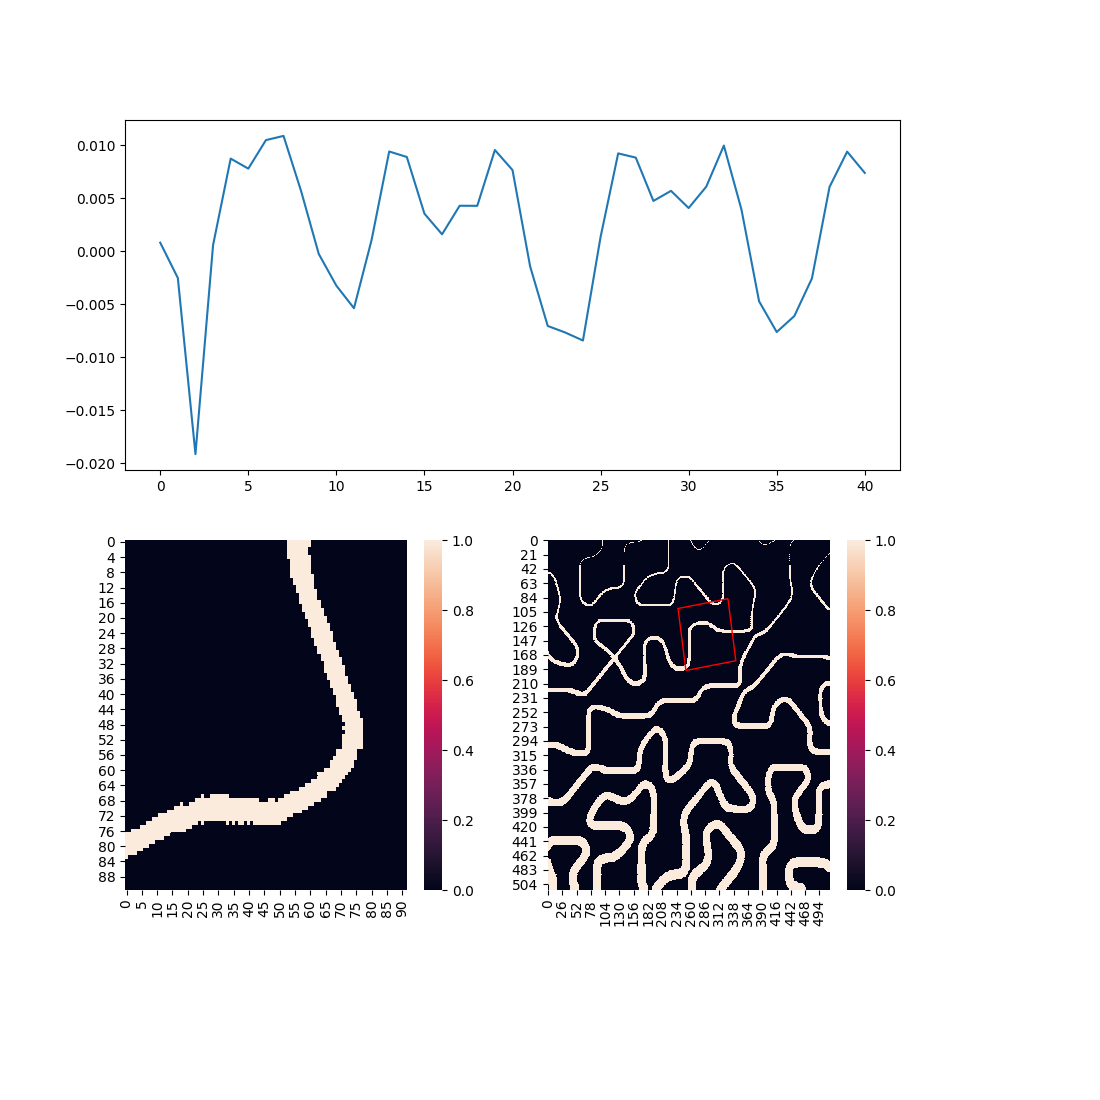

KeyboardInterrupt: 

In [20]:
deb_pip.plot_patch_map_advancement_in_time(dfs[13])


found 3559 spawn points


<IPython.core.display.Javascript object>


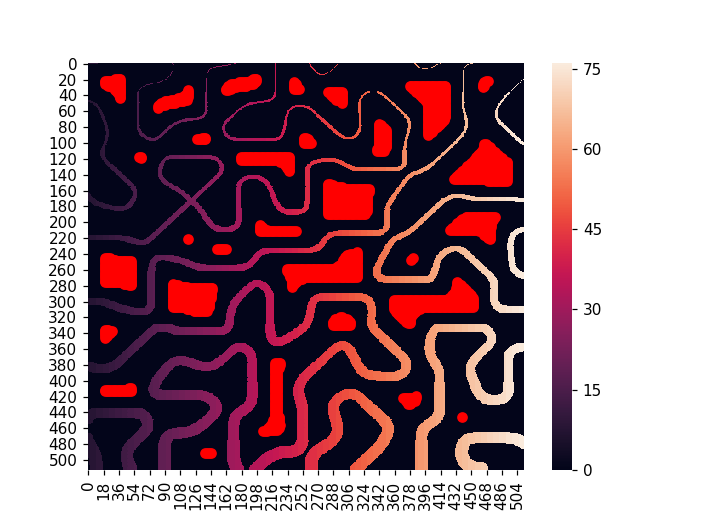

<IPython.core.display.Javascript object>


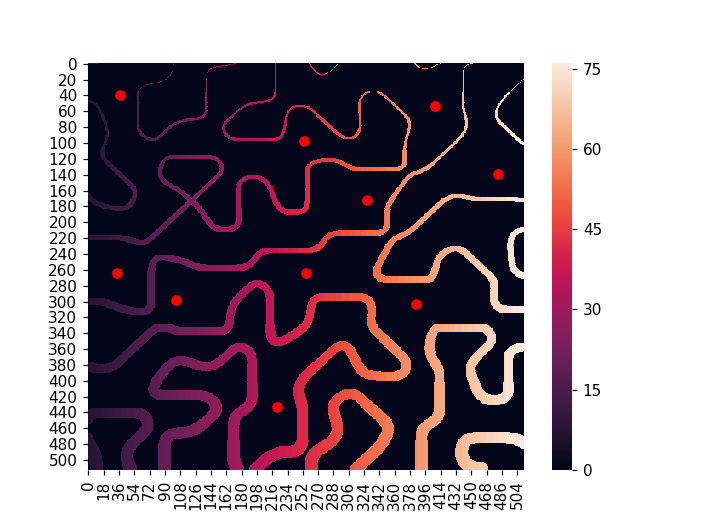

In [29]:
spawn_strat = FlatGroundSpawnStrategy(hm_path=hm, debug=True)

_ = spawn_strat(100)

## Robot in flat ground

In [47]:
_, dfs_flat, hm_flat  = map2dfs('/home/francesco/Documents/Master-Thesis/core/maps/test/flat.png'
                               , '/home/francesco/Desktop/carino/vaevictis/data/train_no_tail/val/csvs/flat/*.csv'
                              )

/home/francesco/Desktop/carino/vaevictis/data/train_no_tail/val/csvs/flat/*.csv
10


<IPython.core.display.Javascript object>


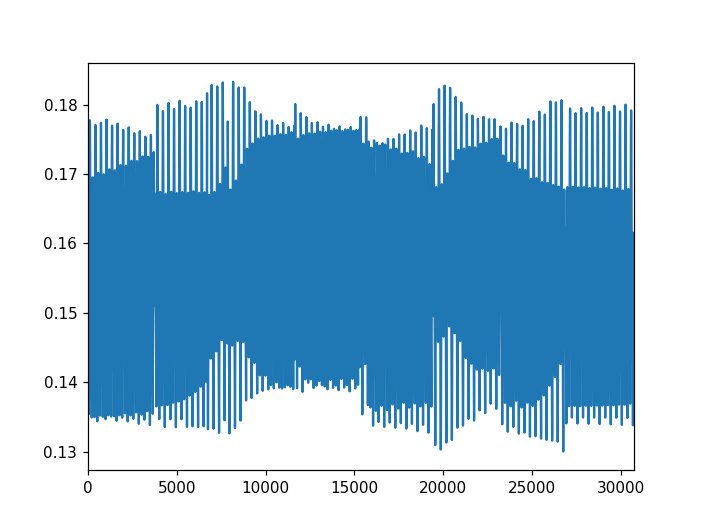

<IPython.core.display.Javascript object>


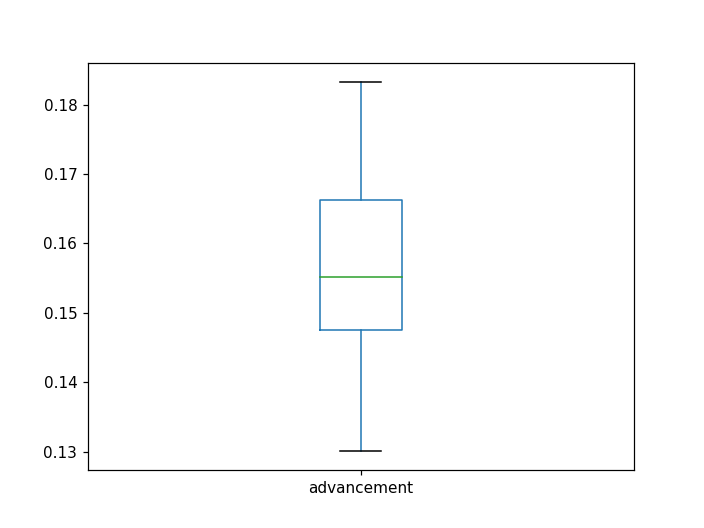

mean=0.15639412960490268


In [48]:
plot_stats(concat_dfs(dfs_flat))